In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.models import Model, Sequential #Functional API
from keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, SGD, RMSprop

### Displaying Images

In [2]:
picture_size = 48
path = "dataset/combined/"

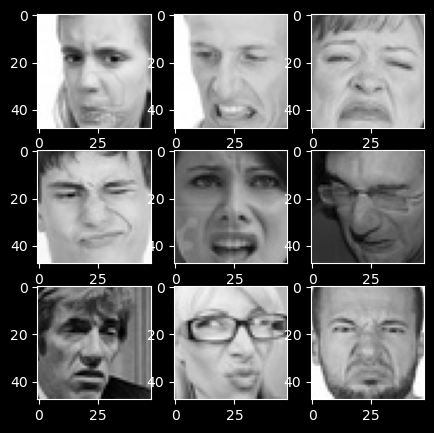

In [3]:
expression = 'disgust'

plt.style.use('dark_background')
plt.figure(figsize = (5,5))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(path+"train/"+expression+"/" +
                 os.listdir(path+"train/"+expression+"/")[i] , target_size = (picture_size,picture_size))
  plt.imshow(img)
plt.show()


### Training and Validation Data

In [4]:
batch_size = 128 #how many training eq in 1 iteration

datagen_train = ImageDataGenerator()
datagen_test = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
test_set = datagen_test.flow_from_directory(path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


Found 29241 images belonging to 7 classes.
Found 7395 images belonging to 7 classes.


### Model Building

In [5]:
from keras.optimizers import Adam
from keras.metrics import Accuracy, Recall, Precision
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [6]:
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.xception import Xception
from keras.regularizers import l2

In [7]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

In [8]:
def simple_CNN(input_shape, num_classes):
  model = Sequential()

  #1st CNN layer
  model.add(Conv2D(64,(3,3), padding = 'same', input_shape = (48,48,1))) #(3,3) is kernel size, 64 filters in number, padding same means padding is same on each side
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #2nd CNN layer
  model.add(Conv2D(128,(5,5), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #3rd CNN layer
  model.add(Conv2D(512,(3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #4th CNN layer
  model.add(Conv2D(512,(3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) #collapse the ip to 1d array to feed into fc easily

  #1st FC layer (fully connected)
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  #2nd FC layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7, activation = 'softmax'))
  return model



In [10]:
model1 = simple_CNN((48, 48, 1), 7)
opt = Adam(learning_rate = 0.0001)
model1.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)      

### Fitting the model

In [12]:
# parameters
batch_size = 32
num_epochs = 20
input_shape = (64, 64, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50


In [13]:
# parameters
batch_size = 128
epochs = 50
input_shape = (48,48, 1)
num_classes = 7

# callbacks
checkpoint = ModelCheckpoint(filepath = "base_cnn.h5", monitor = 'val_acc', verbose = 1, save_best_ony = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

cnn = model1.fit_generator(generator = train_set,
                              steps_per_epoch = train_set.n//train_set.batch_size,
                              epochs = epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks = callbacks_list
                              )

Epoch 1/50


C:\Users\VIT-AP\AppData\Local\Temp\ipykernel_13100\1564237493.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn = model1.fit_generator(generator = train_set,




228/228 [==============================] - ETA: 0s - loss: 2.0090 - accuracy: 0.2400
Epoch 1: saving model to base_cnn.h5
228/228 [==============================] - 118s 506ms/step - loss: 2.0090 - accuracy: 0.2400 - val_loss: 1.7218 - val_accuracy: 0.3178 - lr: 1.0000e-04
Epoch 2/50


C:\Users\VIT-AP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


228/228 [==============================] - ETA: 0s - loss: 1.8054 - accuracy: 0.3079
Epoch 2: saving model to base_cnn.h5
228/228 [==============================] - 125s 548ms/step - loss: 1.8054 - accuracy: 0.3079 - val_loss: 1.7044 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 3/50
228/228 [==============================] - ETA: 0s - loss: 1.7062 - accuracy: 0.3462
Epoch 3: saving model to base_cnn.h5
228/228 [==============================] - 121s 529ms/step - loss: 1.7062 - accuracy: 0.3462 - val_loss: 1.7366 - val_accuracy: 0.3535 - lr: 1.0000e-04
Epoch 4/50
228/228 [==============================] - ETA: 0s - loss: 1.6411 - accuracy: 0.3684
Epoch 4: saving model to base_cnn.h5
228/228 [==============================] - 144s 633ms/step - loss: 1.6411 - accuracy: 0.3684 - val_loss: 1.5955 - val_accuracy: 0.3928 - lr: 1.0000e-04
Epoch 5/50
228/228 [==============================] - ETA: 0s - loss: 1.5809 - accuracy: 0.3909
Epoch 5: saving model to base_cnn.h5
228/228 [==============

### Plotting Accuracy and Loss

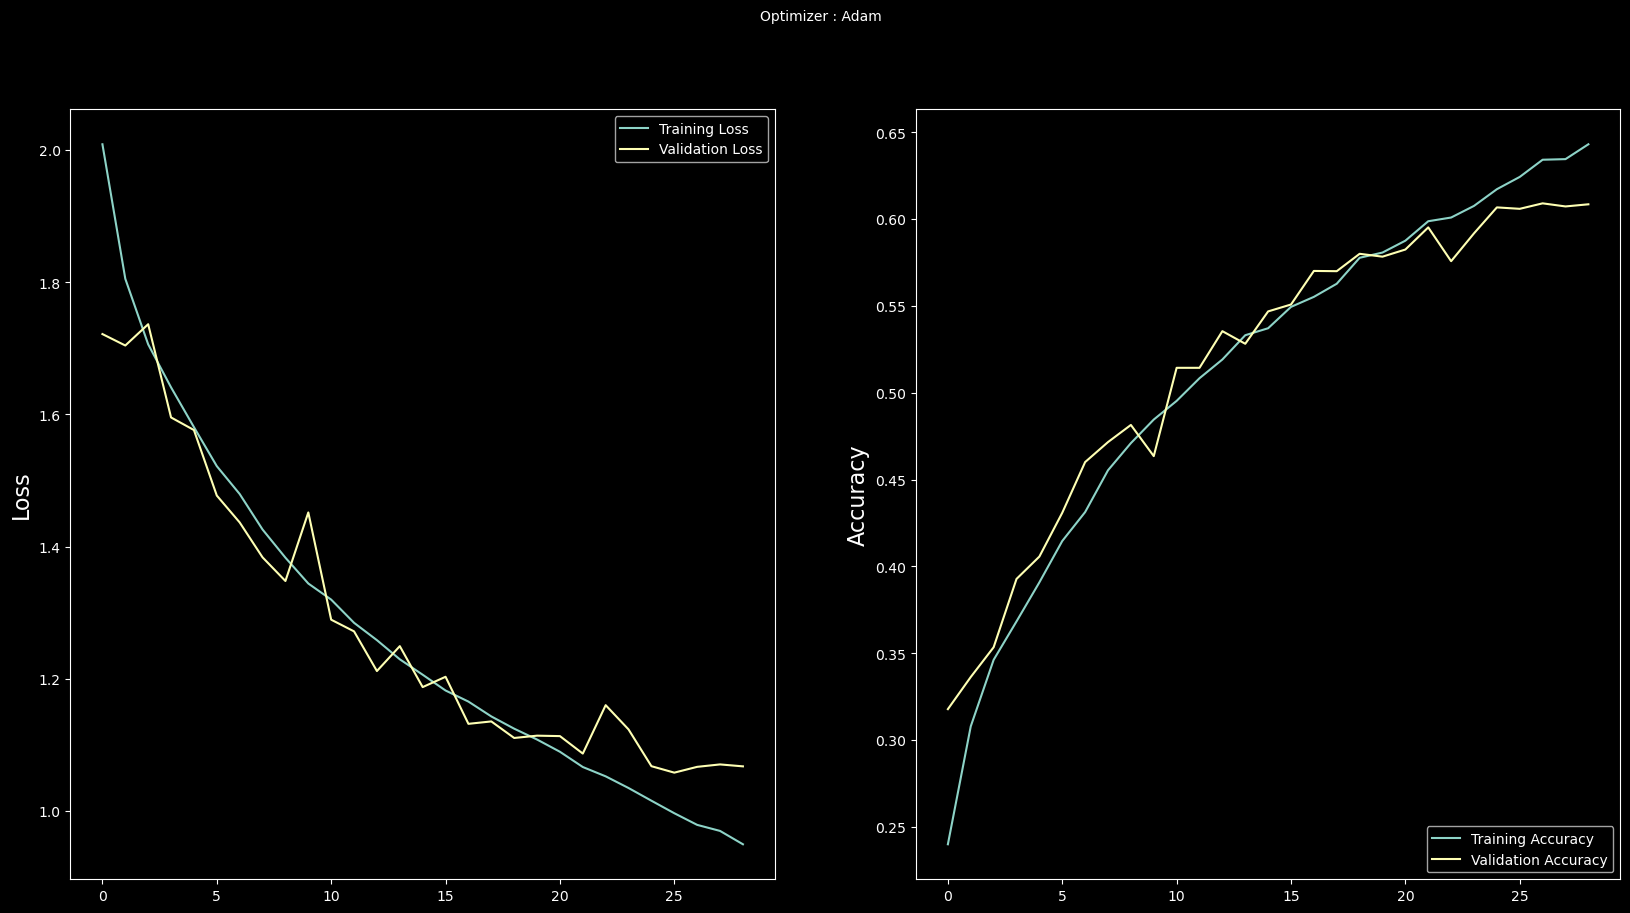

In [20]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(cnn.history['loss'], label='Training Loss')
plt.plot(cnn.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(cnn.history['accuracy'], label='Training Accuracy')
plt.plot(cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()